In [1]:
#pip install torchsummary

In [1]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# # For mutliple devices (GPUs: 4, 5, 6, 7)
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"
from models import resnet

In [2]:
import random
import numpy as np
import torch
from torch import nn, optim
import learn2learn as l2l
from torchvision.models import resnet18
import torchvision
from torchvision import transforms
from learn2learn.data import TaskDataset
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)
import torch.nn.functional as F
import random
from torchsummary import torchsummary
import higher

from jupyterplot import ProgressPlot
import numpy as np
import time
import mlogger


In [3]:
#No randomization
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
if torch.cuda.device_count():
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda')
    print("Device:", device)

Device: cuda


In [4]:
# #Dataset
# # transforms
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))])

# dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)



In [5]:
# #MetaDataset MNIST or Custom Dataset
# dataset = l2l.data.MetaDataset(dataset)
# ways = 10
# shots = 1
# transforms = [
#     NWays(dataset, n=ways),
#     KShots(dataset, k=shots),
#     LoadData(dataset),
# ]
# tasksets = TaskDataset(dataset, transforms, num_tasks=5)
# # MetaDataset Sampling
# for task in tasksets:
#     X, y = task
#     print(y)

In [6]:
#Builtin-MetaDatasets
dataset_name = "mini-imagenet"
# "omniglot"
# "mini-imagenet", 
# "fc100", 
# "cifarfs", 
# "tiered-imagenet"

ways = 5
shots = 1
meta_batch= 32
# Create Tasksets using the benchmark interface
tasksets = l2l.vision.benchmarks.get_tasksets(dataset_name,
                                              train_samples=2*shots,
                                              train_ways=ways,
                                              test_samples=2*shots,
                                              test_ways=ways,
                                              root='~/data',
                                              num_tasks=-1)

In [7]:
# Separate data into adaptation/evalutation sets
# adaptation_indices = np.zeros(X.size(0), dtype=bool)
# adaptation_indices[np.arange(shots*ways) * 2] = True
# evaluation_indices = torch.from_numpy(~adaptation_indices)
# adaptation_indices = torch.from_numpy(adaptation_indices)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X.size: torch.Size([10, 3, 84, 84])


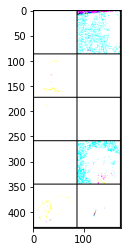

In [8]:
import matplotlib.pylab as plt
from torchvision import utils
X, y = tasksets.train.sample()
print("X.size:", X.size())
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [9]:
def get_indices(X, ways, shots):
    # Separate data into Meta-Train/Meta-Test sets
    meta_train_indices = np.zeros(X.size(0), dtype=bool)
    # print("X:", X.size())
    meta_train_indices[np.arange(shots * ways) * 2] = True
    meta_test_indices = torch.from_numpy(~meta_train_indices)
    meta_train_indices = torch.from_numpy(meta_train_indices)
    return meta_train_indices, meta_test_indices

def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


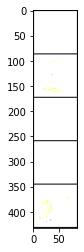

In [10]:
meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
#Adaptation Data
grid = utils.make_grid(X[meta_train_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

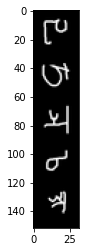

In [24]:
#Adaptation Data
grid = utils.make_grid(X[meta_test_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Validation: tensor([1, 1, 3, 3, 0, 0, 4, 4, 2, 2])


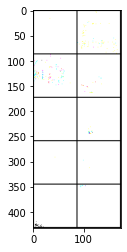

In [11]:
X, y = tasksets.validation.sample()
print("Validation:", y)
grid = utils.make_grid(X, nrow=shots*2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test: tensor([2, 2, 4, 4, 3, 3, 1, 1, 0, 0])


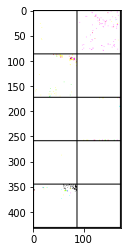

In [12]:
X, y = tasksets.test.sample()
print("Test:", y)
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [14]:
# model = resnet.ResNet18S(out_dim=ways).to(device)
model = resnet18(pretrained=True).to(device)

#resnet18(pretrained=True).to(device)
# for param in model.parameters():
#     param.requires_grad = False
num_ftrs = model.fc.in_features

# num_ftrs 
model.fc = nn.Linear(num_ftrs, ways).to(device)
print(model)
# print(model(torch.rand((1,3,84,84)).to(device)))
# torchsummary.summary(model, input_size= (3, 84, 84))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# print(model.conv1.weight[0].grad)

In [16]:
meta_lr = 0.005
fast_lr = 0.01
adaptation_steps = 1
optim_meta = optim.Adam(model.parameters(), lr=meta_lr)



In [ ]:
epochs = 10000000
# pp = ProgressPlot(plot_names=["ACC", "LOSS"],
#                   line_names=["SS", "QS"])

# 
WANDB_LOGGER = True
if(WANDB_LOGGER):
    import wandb
    wandb.init(project="JMaml", entity="hikmatkhan-")
    wandb.watch(model, log_freq=10)
    wandb.log({"Dataset":dataset_name,
              "Ways":ways,
              "Shots":shots,
              "Meta Batch": meta_batch,
              "Adaptation Step": adaptation_steps})
if __name__ == "__main__":
    
#     meta_train_spt_loss = mlogger.metric.Average()
#     meta_train_spt_acc = mlogger.metric.Average()
#     meta_train_qry_loss = mlogger.metric.Average()
#     meta_train_qry_acc = mlogger.metric.Average()
    
    for e in range(epochs):
        optim_meta.zero_grad()
        meta_train_loss = mlogger.metric.Average()
        meta_train_acc = mlogger.metric.Average()
        meta_val_loss = mlogger.metric.Average()
        meta_val_acc = mlogger.metric.Average()
        meta_test_loss = mlogger.metric.Average()
        meta_test_acc = mlogger.metric.Average()
        for t in range(meta_batch):
            X, y = tasksets.train.sample()
            
            X, y = X.to(device), y.to(device)
#             print(X.size())
            meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
            optim_fast = optim.SGD(model.parameters(), lr=fast_lr)
            with higher.innerloop_ctx(model=model, opt=optim_fast, copy_initial_weights=False
                                     ) as (fmodel, diff_opp):
                
                
#                 print(fmodel.conv1.weight[0].grad)
                for a in range(adaptation_steps):
                    y_prd = fmodel(X[meta_train_indices])
#                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                    meta_train_spt_loss = F.cross_entropy(y_prd, y[meta_train_indices])
#                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                    diff_opp.step(meta_train_spt_loss)
#                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
#                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)
                
                y_prd = fmodel(X[meta_train_indices])
                meta_train_acc.update(accuracy(y_prd, y[meta_test_indices]))
                meta_train_qry_loss = F.cross_entropy(y_prd, y[meta_test_indices])
                meta_train_loss.update(meta_train_qry_loss.detach().cpu().item())
                
                meta_train_qry_loss.backward()
    

        optim_meta.step()
        if(WANDB_LOGGER):
            wandb.log({"Meta Update": e})
        print("Meta-Update")
        
        for t in range(meta_batch):
            X_val, y_val = tasksets.validation.sample()
            X_val, y_val = X_val.to(device), y_val.to(device)
            
#             print(X.size())
            meta_train_indices, meta_test_indices = get_indices(X=X_val, ways=ways, shots=shots)
            optim_fast = optim.SGD(model.parameters(), lr=fast_lr)
            with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False
                                     ) as (fmodel, diff_opp):
                
                
#                 print(fmodel.conv1.weight[0].grad)
                for a in range(adaptation_steps):
                    y_prd = fmodel(X_val[meta_train_indices])
#                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                    meta_val_spt_loss = F.cross_entropy(y_prd, y_val[meta_train_indices])
#                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                    diff_opp.step(meta_val_spt_loss)
#                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
#                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)
                
                y_prd = fmodel(X_val[meta_train_indices])
                meta_val_acc.update(accuracy(y_prd, y_val[meta_test_indices]))
                meta_val_qry_loss = F.cross_entropy(y_prd, y_val[meta_test_indices])
                meta_val_loss.update(meta_val_qry_loss.detach().cpu().item())
                
                
                
        for t in range(meta_batch):
            X_test, y_test = tasksets.test.sample()
            X_test, y_test = X_test.to(device), y_test.to(device)
            
            meta_train_indices, meta_test_indices = get_indices(X=X_test, ways=ways, shots=shots)
            optim_fast = optim.SGD(model.parameters(), lr=fast_lr)
            with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False
                                     ) as (fmodel, diff_opp):
                
                
#                 print(fmodel.conv1.weight[0].grad)
                for a in range(adaptation_steps):
                    y_prd = fmodel(X_test[meta_train_indices])
#                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                    meta_test_spt_loss = F.cross_entropy(y_prd, y_test[meta_train_indices])
#                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                    diff_opp.step(meta_test_spt_loss)
#                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
#                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)
                
                y_prd = fmodel(X_test[meta_train_indices])
                meta_test_acc.update(accuracy(y_prd, y_test[meta_test_indices]))
                meta_test_qry_loss = F.cross_entropy(y_prd, y_test[meta_test_indices])
                meta_test_loss.update(meta_test_qry_loss.detach().cpu().item())
                
                
#                 meta_train_qry_loss.backward()
    
        if(WANDB_LOGGER):
            wandb.log({
                   "Meta Train Acc": meta_train_acc.value,
                   "Meta Train Loss": meta_train_loss.value,
                    "Meta Val Acc": meta_val_acc.value,
                    "Meta Val Loss": meta_val_loss.value,
                    "Meta Test Acc": meta_test_acc.value,
                    "Meta Test Loss": meta_test_loss.value
                   })
        print("Epoch|", e, "|", "Meta Train Acc:", meta_train_acc.value, " Meta Train Loss:", meta_train_loss.value,
             "Meta Val Acc:", meta_val_acc.value, " Meta Val Loss:", meta_val_loss.value,
             "Meta Test Acc:", meta_test_acc.value, " Meta Test Loss:", meta_test_loss.value)


        meta_train_loss.reset()
        meta_train_acc.reset()
        meta_val_loss.reset()
        meta_val_acc.reset()
        meta_test_loss.reset()
        meta_test_acc.reset()
                
                
    

Dataset,mini-imagenet
Ways,5
Shots,1
Meta Batch,32
Adaptation Step,1
_runtime,18
_timestamp,1629291934
_step,1


Ways,▁
Shots,▁
Meta Batch,▁
Adaptation Step,▁
_runtime,▁█
_timestamp,▁█
_step,▁█


Meta-Update
Epoch| 0 | Meta Train Acc: 1.0  Meta Train Loss: 0.1315416774014011 Meta Val Acc: 0.968750001862645  Meta Val Loss: 0.0715633340878412 Meta Test Acc: 0.9937500003725291  Meta Test Loss: 0.06031430397706572
Meta-Update
Epoch| 1 | Meta Train Acc: 0.987500000745058  Meta Train Loss: 0.07112475991016252 Meta Val Acc: 0.9125000052154064  Meta Val Loss: 0.36825359904833016 Meta Test Acc: 0.9187500048428773  Meta Test Loss: 0.31364921759814024
Meta-Update
Epoch| 2 | Meta Train Acc: 0.9250000044703482  Meta Train Loss: 0.21725765334849714 Meta Val Acc: 0.8562500076368451  Meta Val Loss: 0.6849161203863331 Meta Test Acc: 0.8687500068917872  Meta Test Loss: 0.7613720877307054
Meta-Update
Epoch| 3 | Meta Train Acc: 0.8250000071711838  Meta Train Loss: 0.8769004771020263 Meta Val Acc: 0.6187500148080288  Meta Val Loss: 1.973870061337948 Meta Test Acc: 0.7062500114552677  Meta Test Loss: 1.679661491245497
Meta-Update
Epoch| 4 | Meta Train Acc: 0.6937500126659868  Meta Train Loss: 1.2572

Meta-Update
Epoch| 36 | Meta Train Acc: 0.8125000102445485  Meta Train Loss: 0.5593306589871645 Meta Val Acc: 0.7562500103376808  Meta Val Loss: 0.8459407272748649 Meta Test Acc: 0.6937500135973098  Meta Test Loss: 0.8216462680138648
Meta-Update
Epoch| 37 | Meta Train Acc: 0.7437500115483999  Meta Train Loss: 0.5799943716265258 Meta Val Acc: 0.6937500117346643  Meta Val Loss: 1.1265436825342479 Meta Test Acc: 0.6562500121071934  Meta Test Loss: 0.9415282509289682
Meta-Update
Epoch| 38 | Meta Train Acc: 0.7062500165775418  Meta Train Loss: 0.9287915006279943 Meta Val Acc: 0.7375000109896066  Meta Val Loss: 0.8940004000905901 Meta Test Acc: 0.681250016205013  Meta Test Loss: 0.9014059654437004
Meta-Update
Epoch| 39 | Meta Train Acc: 0.6437500147148967  Meta Train Loss: 0.9348525302484634 Meta Val Acc: 0.687500011175871  Meta Val Loss: 0.8218269250355662 Meta Test Acc: 0.7562500108033419  Meta Test Loss: 0.6894609788432716
Meta-Update
Epoch| 40 | Meta Train Acc: 0.7375000123865901  Meta T

Epoch| 71 | Meta Train Acc: 0.8875000067055225  Meta Train Loss: 0.3328514907043427 Meta Val Acc: 0.9000000059604643  Meta Val Loss: 0.2971334318863229 Meta Test Acc: 0.8812500061467291  Meta Test Loss: 0.35039477190002805
Meta-Update
Epoch| 72 | Meta Train Acc: 0.9062500055879354  Meta Train Loss: 0.30471555865369737 Meta Val Acc: 0.9562500026077032  Meta Val Loss: 0.23775097652105615 Meta Test Acc: 0.9312500040978192  Meta Test Loss: 0.25787242630030954
Meta-Update
Epoch| 73 | Meta Train Acc: 0.9125000052154066  Meta Train Loss: 0.2689046243322083 Meta Val Acc: 0.9312500040978194  Meta Val Loss: 0.2392811952740885 Meta Test Acc: 0.8812500070780515  Meta Test Loss: 0.2898352416232227
Meta-Update
Epoch| 74 | Meta Train Acc: 0.950000002980232  Meta Train Loss: 0.20115423499373716 Meta Val Acc: 0.9375000037252903  Meta Val Loss: 0.1712963416648563 Meta Test Acc: 0.9375000037252903  Meta Test Loss: 0.2037739781080745
Meta-Update
Epoch| 75 | Meta Train Acc: 0.9250000044703484  Meta Train L

Meta-Update
Epoch| 106 | Meta Train Acc: 0.9437500033527613  Meta Train Loss: 0.14546614018036055 Meta Val Acc: 0.9125000052154065  Meta Val Loss: 0.17329553113086155 Meta Test Acc: 0.9625000022351742  Meta Test Loss: 0.10917701399012003
Meta-Update
Epoch| 107 | Meta Train Acc: 0.9500000029802323  Meta Train Loss: 0.18299178708002728 Meta Val Acc: 0.9500000029802322  Meta Val Loss: 0.13205022187321444 Meta Test Acc: 0.9750000014901162  Meta Test Loss: 0.10439512057200777
Meta-Update
Epoch| 108 | Meta Train Acc: 0.9562500026077032  Meta Train Loss: 0.12456422207469588 Meta Val Acc: 0.981250001117587  Meta Val Loss: 0.0914674726736848 Meta Test Acc: 0.9312500040978192  Meta Test Loss: 0.15779094268873448
Meta-Update
Epoch| 109 | Meta Train Acc: 0.9937500003725291  Meta Train Loss: 0.07879935431265035 Meta Val Acc: 0.9437500033527612  Meta Val Loss: 0.1563144485116936 Meta Test Acc: 0.9187500048428775  Meta Test Loss: 0.18631161591838463
Meta-Update
Epoch| 110 | Meta Train Acc: 0.96875000

Meta-Update
Epoch| 141 | Meta Train Acc: 0.9000000059604646  Meta Train Loss: 0.3570378576405346 Meta Val Acc: 0.8625000081956387  Meta Val Loss: 0.4212094797985628 Meta Test Acc: 0.8312500081956385  Meta Test Loss: 0.48680410638917243
Meta-Update
Epoch| 142 | Meta Train Acc: 0.862500007264316  Meta Train Loss: 0.41770309401908884 Meta Val Acc: 0.7687500109896064  Meta Val Loss: 0.5696651331381875 Meta Test Acc: 0.8250000104308127  Meta Test Loss: 0.607981756562367
Meta-Update
Epoch| 143 | Meta Train Acc: 0.7625000099651519  Meta Train Loss: 0.6204327819868921 Meta Val Acc: 0.8062500078231095  Meta Val Loss: 0.536093653761782 Meta Test Acc: 0.8437500069849194  Meta Test Loss: 0.44561903460999014
Meta-Update
Epoch| 144 | Meta Train Acc: 0.8500000070780516  Meta Train Loss: 0.46200150065124035 Meta Val Acc: 0.8500000080093743  Meta Val Loss: 0.39737637981306767 Meta Test Acc: 0.9187500048428776  Meta Test Loss: 0.2919446917949244
Meta-Update
Epoch| 145 | Meta Train Acc: 0.900000005029141

Meta-Update
Epoch| 176 | Meta Train Acc: 0.9375000037252903  Meta Train Loss: 0.1727344393002567 Meta Val Acc: 0.9187500048428775  Meta Val Loss: 0.2626321211282629 Meta Test Acc: 0.9375000037252903  Meta Test Loss: 0.20090469175192993
Meta-Update
Epoch| 177 | Meta Train Acc: 0.9125000052154064  Meta Train Loss: 0.21709231132990686 Meta Val Acc: 0.9562500026077031  Meta Val Loss: 0.20412997996027107 Meta Test Acc: 0.9687500018626451  Meta Test Loss: 0.13178793867700728
Meta-Update
Epoch| 178 | Meta Train Acc: 0.9062500055879354  Meta Train Loss: 0.21970809458798615 Meta Val Acc: 0.9625000022351741  Meta Val Loss: 0.13652552651183214 Meta Test Acc: 0.9562500026077032  Meta Test Loss: 0.15094991950900288
Meta-Update
Epoch| 179 | Meta Train Acc: 0.9187500039115546  Meta Train Loss: 0.2319766630680533 Meta Val Acc: 0.9437500024214387  Meta Val Loss: 0.14970942169020415 Meta Test Acc: 0.9375000037252902  Meta Test Loss: 0.21316624491737468
Meta-Update
Epoch| 180 | Meta Train Acc: 0.93750000

Meta-Update
Epoch| 211 | Meta Train Acc: 0.8875000057742  Meta Train Loss: 0.35306432755896816 Meta Val Acc: 0.9187500048428774  Meta Val Loss: 0.22395762157975685 Meta Test Acc: 0.8750000060535966  Meta Test Loss: 0.5184003929607571
Meta-Update
Epoch| 212 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.35921943327412015 Meta Val Acc: 0.8937500054016709  Meta Val Loss: 0.28370053294929665 Meta Test Acc: 0.8937500063329937  Meta Test Loss: 0.22350354850641457
Meta-Update
Epoch| 213 | Meta Train Acc: 0.8875000057742  Meta Train Loss: 0.28174615647003526 Meta Val Acc: 0.9437500033527612  Meta Val Loss: 0.19616522630531102 Meta Test Acc: 0.9125000052154062  Meta Test Loss: 0.2579419769172092
Meta-Update
Epoch| 214 | Meta Train Acc: 0.9312500040978192  Meta Train Loss: 0.15488793629992864 Meta Val Acc: 0.9375000037252903  Meta Val Loss: 0.20730761231970973 Meta Test Acc: 0.9062500055879354  Meta Test Loss: 0.284501503338106
Meta-Update
Epoch| 215 | Meta Train Acc: 0.950000002980232

Meta-Update
Epoch| 246 | Meta Train Acc: 0.9312500031664966  Meta Train Loss: 0.192800671176883 Meta Val Acc: 0.975000001490116  Meta Val Loss: 0.12396378818084487 Meta Test Acc: 0.9437500033527613  Meta Test Loss: 0.1577356862399029
Meta-Update
Epoch| 247 | Meta Train Acc: 0.9250000044703485  Meta Train Loss: 0.22657826021895744 Meta Val Acc: 0.9687500018626449  Meta Val Loss: 0.14970586405252104 Meta Test Acc: 0.9500000029802323  Meta Test Loss: 0.16152276864158918
Meta-Update
Epoch| 248 | Meta Train Acc: 0.943750002421439  Meta Train Loss: 0.15844365625525828 Meta Val Acc: 0.981250001117587  Meta Val Loss: 0.07876230729016237 Meta Test Acc: 0.9437500033527612  Meta Test Loss: 0.1309810495076818
Meta-Update
Epoch| 249 | Meta Train Acc: 0.9625000022351743  Meta Train Loss: 0.0983582776825642 Meta Val Acc: 0.9750000014901161  Meta Val Loss: 0.1051845739957571 Meta Test Acc: 0.9687500018626451  Meta Test Loss: 0.14792409577785293
Meta-Update
Epoch| 250 | Meta Train Acc: 0.95625000260770

Meta-Update
Epoch| 281 | Meta Train Acc: 0.9687500018626453  Meta Train Loss: 0.10088906976216093 Meta Val Acc: 0.9625000022351741  Meta Val Loss: 0.10256267106160522 Meta Test Acc: 0.968750001862645  Meta Test Loss: 0.12423524444056969
Meta-Update
Epoch| 282 | Meta Train Acc: 0.9750000014901161  Meta Train Loss: 0.08332056176550395 Meta Val Acc: 0.9812500011175871  Meta Val Loss: 0.04893699094100157 Meta Test Acc: 0.9687500018626453  Meta Test Loss: 0.07327684478059382
Meta-Update
Epoch| 283 | Meta Train Acc: 0.9875000007450578  Meta Train Loss: 0.06673457808210516 Meta Val Acc: 0.968750001862645  Meta Val Loss: 0.07904337100626432 Meta Test Acc: 0.981250001117587  Meta Test Loss: 0.07947610535848071
Meta-Update
Epoch| 284 | Meta Train Acc: 0.981250001117587  Meta Train Loss: 0.05741500382100639 Meta Val Acc: 0.981250001117587  Meta Val Loss: 0.07204545682679962 Meta Test Acc: 0.9750000014901161  Meta Test Loss: 0.06562890691839131
Meta-Update
Epoch| 285 | Meta Train Acc: 0.9875000007

Meta-Update
Epoch| 316 | Meta Train Acc: 0.9875000007450578  Meta Train Loss: 0.04772927463000091 Meta Val Acc: 0.9937500003725291  Meta Val Loss: 0.028806887568180176 Meta Test Acc: 0.9875000007450578  Meta Test Loss: 0.040599926831873745
Meta-Update
Epoch| 317 | Meta Train Acc: 0.9750000014901161  Meta Train Loss: 0.11073291016634805 Meta Val Acc: 0.9937500003725291  Meta Val Loss: 0.036890553213197556 Meta Test Acc: 0.9875000007450581  Meta Test Loss: 0.0400288551303447
Meta-Update
Epoch| 318 | Meta Train Acc: 0.981250001117587  Meta Train Loss: 0.08844297360860764 Meta Val Acc: 0.9937500003725291  Meta Val Loss: 0.018643179251739635 Meta Test Acc: 0.9875000007450578  Meta Test Loss: 0.028881390473316053
Meta-Update
Epoch| 319 | Meta Train Acc: 1.0  Meta Train Loss: 0.016716755821107654 Meta Val Acc: 0.9812500011175871  Meta Val Loss: 0.05747932958001907 Meta Test Acc: 1.0  Meta Test Loss: 0.024608218625871814
Meta-Update
Epoch| 320 | Meta Train Acc: 0.9875000007450581  Meta Train L

Meta-Update
Epoch| 351 | Meta Train Acc: 0.9750000014901161  Meta Train Loss: 0.08800352593061683 Meta Val Acc: 0.975000001490116  Meta Val Loss: 0.06672697912790682 Meta Test Acc: 0.9562500026077031  Meta Test Loss: 0.1399608271103716
Meta-Update
Epoch| 352 | Meta Train Acc: 0.9687500018626451  Meta Train Loss: 0.14123614291884223 Meta Val Acc: 0.9312500040978192  Meta Val Loss: 0.21527421890050394 Meta Test Acc: 0.981250001117587  Meta Test Loss: 0.0781314464056777
Meta-Update
Epoch| 353 | Meta Train Acc: 0.9500000029802323  Meta Train Loss: 0.12616431012156681 Meta Val Acc: 0.950000002980232  Meta Val Loss: 0.16871175553023926 Meta Test Acc: 0.9312500040978193  Meta Test Loss: 0.16325725568276533
Meta-Update
Epoch| 354 | Meta Train Acc: 0.9312500040978192  Meta Train Loss: 0.2088050414067765 Meta Val Acc: 0.9750000014901161  Meta Val Loss: 0.08109716584294806 Meta Test Acc: 0.9562500026077033  Meta Test Loss: 0.11558591516313756
Meta-Update
Epoch| 355 | Meta Train Acc: 0.97500000149

Meta-Update
Epoch| 386 | Meta Train Acc: 0.9625000022351741  Meta Train Loss: 0.13736384267940593 Meta Val Acc: 0.981250001117587  Meta Val Loss: 0.04872180057100195 Meta Test Acc: 0.981250001117587  Meta Test Loss: 0.04811162445412266
Meta-Update
Epoch| 387 | Meta Train Acc: 0.9750000014901162  Meta Train Loss: 0.08707693102519444 Meta Val Acc: 0.9687500018626451  Meta Val Loss: 0.09481180392049278 Meta Test Acc: 0.968750001862645  Meta Test Loss: 0.07881066534696396
Meta-Update
Epoch| 388 | Meta Train Acc: 0.975000001490116  Meta Train Loss: 0.07049468950162918 Meta Val Acc: 0.9875000007450578  Meta Val Loss: 0.038058401592934395 Meta Test Acc: 0.9687500018626451  Meta Test Loss: 0.08741812856715116
Meta-Update
Epoch| 389 | Meta Train Acc: 0.9625000022351741  Meta Train Loss: 0.08241373737246245 Meta Val Acc: 0.9750000014901162  Meta Val Loss: 0.0761829873335955 Meta Test Acc: 1.0  Meta Test Loss: 0.038812528569906114
Meta-Update
Epoch| 390 | Meta Train Acc: 0.981250001117587  Meta T

Meta-Update
Epoch| 421 | Meta Train Acc: 0.981250001117587  Meta Train Loss: 0.04447442009188763 Meta Val Acc: 0.9937500003725291  Meta Val Loss: 0.02608082881295105 Meta Test Acc: 0.9937500003725291  Meta Test Loss: 0.020838989045159906
Meta-Update
Epoch| 422 | Meta Train Acc: 0.981250001117587  Meta Train Loss: 0.07971348229875733 Meta Val Acc: 0.9875000007450578  Meta Val Loss: 0.04941291676664149 Meta Test Acc: 0.9500000029802321  Meta Test Loss: 0.1352822621074665
Meta-Update
Epoch| 423 | Meta Train Acc: 0.9750000014901161  Meta Train Loss: 0.05238663376803741 Meta Val Acc: 0.9625000022351741  Meta Val Loss: 0.10686189297985034 Meta Test Acc: 0.9687500018626451  Meta Test Loss: 0.15149943984624764
Meta-Update
Epoch| 424 | Meta Train Acc: 0.9625000022351741  Meta Train Loss: 0.11982811526945619 Meta Val Acc: 0.9875000007450578  Meta Val Loss: 0.045116899720909494 Meta Test Acc: 0.987500000745058  Meta Test Loss: 0.05497850402525725
Meta-Update
Epoch| 425 | Meta Train Acc: 0.9937500

Meta-Update
Epoch| 456 | Meta Train Acc: 0.987500000745058  Meta Train Loss: 0.062287121088502345 Meta Val Acc: 0.981250001117587  Meta Val Loss: 0.10355209426597867 Meta Test Acc: 0.9500000029802322  Meta Test Loss: 0.14525139440183915
Meta-Update
Epoch| 457 | Meta Train Acc: 0.981250001117587  Meta Train Loss: 0.06296170493988029 Meta Val Acc: 0.9562500026077033  Meta Val Loss: 0.137495237998337 Meta Test Acc: 0.968750001862645  Meta Test Loss: 0.08846782526325113
Meta-Update
Epoch| 458 | Meta Train Acc: 0.987500000745058  Meta Train Loss: 0.039911670218089036 Meta Val Acc: 0.9687500018626451  Meta Val Loss: 0.10502823018032359 Meta Test Acc: 0.9500000029802321  Meta Test Loss: 0.12817444700340275
Meta-Update
Epoch| 459 | Meta Train Acc: 0.981250001117587  Meta Train Loss: 0.12955590389719873 Meta Val Acc: 0.9875000007450578  Meta Val Loss: 0.06499083308517589 Meta Test Acc: 0.9812500011175871  Meta Test Loss: 0.06539942145900572
Meta-Update
Epoch| 460 | Meta Train Acc: 0.93125000409

Meta-Update
Epoch| 491 | Meta Train Acc: 0.9687500018626454  Meta Train Loss: 0.08104827864463003 Meta Val Acc: 0.968750001862645  Meta Val Loss: 0.1913713249487045 Meta Test Acc: 0.9875000007450581  Meta Test Loss: 0.07917050121886864
Meta-Update
Epoch| 492 | Meta Train Acc: 0.9625000022351742  Meta Train Loss: 0.0998502973950508 Meta Val Acc: 0.9750000014901162  Meta Val Loss: 0.09004135583018069 Meta Test Acc: 0.9750000014901161  Meta Test Loss: 0.08537191156426616
Meta-Update
Epoch| 493 | Meta Train Acc: 0.9562500026077033  Meta Train Loss: 0.11630980999098033 Meta Val Acc: 0.9687500018626453  Meta Val Loss: 0.12572251858364325 Meta Test Acc: 0.9687500018626453  Meta Test Loss: 0.07735864006826887
Meta-Update
Epoch| 494 | Meta Train Acc: 0.9750000014901161  Meta Train Loss: 0.07702698760749625 Meta Val Acc: 0.9687500018626451  Meta Val Loss: 0.09911844972066321 Meta Test Acc: 0.9562500026077032  Meta Test Loss: 0.1381465958966146
Meta-Update
Epoch| 495 | Meta Train Acc: 0.968750001

Meta-Update
Epoch| 526 | Meta Train Acc: 0.9500000029802321  Meta Train Loss: 0.38983102018744376 Meta Val Acc: 0.9687500018626451  Meta Val Loss: 0.12949930312197466 Meta Test Acc: 0.9437500033527612  Meta Test Loss: 0.23135427560191602
Meta-Update
Epoch| 527 | Meta Train Acc: 0.9437500033527613  Meta Train Loss: 0.2680850467577331 Meta Val Acc: 0.9062500055879356  Meta Val Loss: 0.48269745046854956 Meta Test Acc: 0.9375000037252902  Meta Test Loss: 0.31548665227955996
Meta-Update
Epoch| 528 | Meta Train Acc: 0.9062500055879353  Meta Train Loss: 0.46274281167825393 Meta Val Acc: 0.9062500055879353  Meta Val Loss: 0.6753485967128654 Meta Test Acc: 0.9187500048428774  Meta Test Loss: 0.32601735067328236
Meta-Update
Epoch| 529 | Meta Train Acc: 0.9437500033527612  Meta Train Loss: 0.1376514204312116 Meta Val Acc: 0.9125000052154064  Meta Val Loss: 0.22926421202464553 Meta Test Acc: 0.9125000052154064  Meta Test Loss: 0.36603796907274966
Meta-Update
Epoch| 530 | Meta Train Acc: 0.93125000

Meta-Update
Epoch| 561 | Meta Train Acc: 0.9250000044703485  Meta Train Loss: 0.2444298821610574 Meta Val Acc: 0.8875000067055225  Meta Val Loss: 0.32841157143775485 Meta Test Acc: 0.8875000057742002  Meta Test Loss: 0.28662201770930545
Meta-Update
Epoch| 562 | Meta Train Acc: 0.8875000053085385  Meta Train Loss: 0.25358004680674634 Meta Val Acc: 0.9062500055879354  Meta Val Loss: 0.3387308312121604 Meta Test Acc: 0.8500000080093744  Meta Test Loss: 0.5140574120450767
Meta-Update
Epoch| 563 | Meta Train Acc: 0.8750000065192581  Meta Train Loss: 0.45933662398601877 Meta Val Acc: 0.9375000037252904  Meta Val Loss: 0.18157839502237036 Meta Test Acc: 0.9000000059604646  Meta Test Loss: 0.2958706303688814
Meta-Update
Epoch| 564 | Meta Train Acc: 0.8750000074505805  Meta Train Loss: 0.3456845086766407 Meta Val Acc: 0.9062500055879354  Meta Val Loss: 0.20435759375686757 Meta Test Acc: 0.9000000059604644  Meta Test Loss: 0.3531455741867831
Meta-Update
Epoch| 565 | Meta Train Acc: 0.89375000447

Meta-Update
Epoch| 596 | Meta Train Acc: 0.8812500070780516  Meta Train Loss: 0.3063589831581339 Meta Val Acc: 0.9250000044703486  Meta Val Loss: 0.25449792879226163 Meta Test Acc: 0.8562500067055225  Meta Test Loss: 0.3494247745256871
Meta-Update
Epoch| 597 | Meta Train Acc: 0.9125000052154065  Meta Train Loss: 0.3170888288877905 Meta Val Acc: 0.8937500063329935  Meta Val Loss: 0.2692458614183124 Meta Test Acc: 0.9062500055879354  Meta Test Loss: 0.26425252587068815
Meta-Update
Epoch| 598 | Meta Train Acc: 0.8875000067055225  Meta Train Loss: 0.3149659101618454 Meta Val Acc: 0.9312500040978192  Meta Val Loss: 0.21350203140173107 Meta Test Acc: 0.8750000074505807  Meta Test Loss: 0.25936523952987045
Meta-Update
Epoch| 599 | Meta Train Acc: 0.8875000067055225  Meta Train Loss: 0.2769270265707747 Meta Val Acc: 0.9125000052154064  Meta Val Loss: 0.21987097949022422 Meta Test Acc: 0.9312500040978193  Meta Test Loss: 0.198733093595365
Meta-Update
Epoch| 600 | Meta Train Acc: 0.9250000044703

Meta-Update
Epoch| 631 | Meta Train Acc: 0.9187500048428773  Meta Train Loss: 0.19555373220646288 Meta Val Acc: 0.9562500026077033  Meta Val Loss: 0.15202816223609264 Meta Test Acc: 0.9375000027939677  Meta Test Loss: 0.180234288040083
Meta-Update
Epoch| 632 | Meta Train Acc: 0.9500000029802325  Meta Train Loss: 0.15663372880953833 Meta Val Acc: 0.9312500040978193  Meta Val Loss: 0.16641000569507014 Meta Test Acc: 0.9437500033527613  Meta Test Loss: 0.14488322165107093
Meta-Update
Epoch| 633 | Meta Train Acc: 0.9250000044703484  Meta Train Loss: 0.20981354458490392 Meta Val Acc: 0.9875000007450582  Meta Val Loss: 0.0913587379909586 Meta Test Acc: 0.943750003352761  Meta Test Loss: 0.14631716829353536
Meta-Update
Epoch| 634 | Meta Train Acc: 0.9312500040978192  Meta Train Loss: 0.16769630112685266 Meta Val Acc: 0.9500000029802322  Meta Val Loss: 0.21647802988809414 Meta Test Acc: 0.950000002980232  Meta Test Loss: 0.17604718101210892
Meta-Update
Epoch| 635 | Meta Train Acc: 0.9687500018

Meta-Update
Epoch| 666 | Meta Train Acc: 0.9187500048428775  Meta Train Loss: 0.1937641573240398 Meta Val Acc: 0.9187500048428775  Meta Val Loss: 0.2188746912615898 Meta Test Acc: 0.9125000052154065  Meta Test Loss: 0.32525050437288877
Meta-Update
Epoch| 667 | Meta Train Acc: 0.9437500033527613  Meta Train Loss: 0.176304409178556 Meta Val Acc: 0.9000000059604645  Meta Val Loss: 0.3371615110518179 Meta Test Acc: 0.8437500093132259  Meta Test Loss: 0.5024520562365067
Meta-Update
Epoch| 668 | Meta Train Acc: 0.850000006146729  Meta Train Loss: 0.5861074749554974 Meta Val Acc: 0.9187500048428773  Meta Val Loss: 0.24248532953788535 Meta Test Acc: 0.9312500040978194  Meta Test Loss: 0.25658832261979114
Meta-Update
Epoch| 669 | Meta Train Acc: 0.943750003352761  Meta Train Loss: 0.18518272251822052 Meta Val Acc: 0.9125000052154064  Meta Val Loss: 0.4860170098254458 Meta Test Acc: 0.9375000037252903  Meta Test Loss: 0.4729698735463898
Meta-Update
Epoch| 670 | Meta Train Acc: 0.9375000027939678

Meta-Update
Epoch| 701 | Meta Train Acc: 0.9437500033527613  Meta Train Loss: 0.17046864362782801 Meta Val Acc: 0.9250000044703482  Meta Val Loss: 0.20917703659506506 Meta Test Acc: 0.9312500040978191  Meta Test Loss: 0.24025500539573832
Meta-Update
Epoch| 702 | Meta Train Acc: 0.9375000037252903  Meta Train Loss: 0.16777911377721472 Meta Val Acc: 0.9312500040978192  Meta Val Loss: 0.18327058502472937 Meta Test Acc: 0.943750003352761  Meta Test Loss: 0.1755216544406722
Meta-Update
Epoch| 703 | Meta Train Acc: 0.9375000037252903  Meta Train Loss: 0.21718136925483125 Meta Val Acc: 0.9437500033527613  Meta Val Loss: 0.17924893560120841 Meta Test Acc: 0.9437500033527613  Meta Test Loss: 0.18736064094991892
Meta-Update
Epoch| 704 | Meta Train Acc: 0.9375000037252903  Meta Train Loss: 0.2527172963746125 Meta Val Acc: 0.9437500024214386  Meta Val Loss: 0.16669882816495374 Meta Test Acc: 0.9125000042840838  Meta Test Loss: 0.27741167583735654
Meta-Update
Epoch| 705 | Meta Train Acc: 0.93125000

Meta-Update
Epoch| 736 | Meta Train Acc: 0.9375000037252903  Meta Train Loss: 0.2138935907860287 Meta Val Acc: 0.9375000037252903  Meta Val Loss: 0.190759504417656 Meta Test Acc: 0.8937500054016709  Meta Test Loss: 0.39343833709426684
Meta-Update
Epoch| 737 | Meta Train Acc: 0.875000005122274  Meta Train Loss: 0.4706455551786347 Meta Val Acc: 0.9062500055879353  Meta Val Loss: 0.33293286547996087 Meta Test Acc: 0.9312500040978193  Meta Test Loss: 0.31706180407491047
Meta-Update
Epoch| 738 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.29418460791930556 Meta Val Acc: 0.9000000040978196  Meta Val Loss: 0.2925483071885538 Meta Test Acc: 0.8812500070780515  Meta Test Loss: 0.357994258753024
Meta-Update
Epoch| 739 | Meta Train Acc: 0.9375000037252902  Meta Train Loss: 0.18592705686023692 Meta Val Acc: 0.8812500070780513  Meta Val Loss: 0.4808115324995013 Meta Test Acc: 0.8687500078231095  Meta Test Loss: 0.41367456439184014
Meta-Update
Epoch| 740 | Meta Train Acc: 0.91875000484287

Meta-Update
Epoch| 771 | Meta Train Acc: 0.8937500063329936  Meta Train Loss: 0.30728436799836345 Meta Val Acc: 0.9562500026077032  Meta Val Loss: 0.141491243528435 Meta Test Acc: 0.8812500070780516  Meta Test Loss: 0.29121334094088525
Meta-Update
Epoch| 772 | Meta Train Acc: 0.9500000029802321  Meta Train Loss: 0.18147590884473183 Meta Val Acc: 0.9125000052154064  Meta Val Loss: 0.23658169701229778 Meta Test Acc: 0.9437500033527613  Meta Test Loss: 0.18148000937071632
Meta-Update
Epoch| 773 | Meta Train Acc: 0.9187500048428775  Meta Train Loss: 0.27716898989456235 Meta Val Acc: 0.9312500040978193  Meta Val Loss: 0.19720485402649496 Meta Test Acc: 0.9375000037252903  Meta Test Loss: 0.21766902379749803
Meta-Update
Epoch| 774 | Meta Train Acc: 0.9687500018626451  Meta Train Loss: 0.12097641997388564 Meta Val Acc: 0.9125000052154064  Meta Val Loss: 0.2358353525924031 Meta Test Acc: 0.9000000059604647  Meta Test Loss: 0.28509316520649014
Meta-Update
Epoch| 775 | Meta Train Acc: 0.90000000

Meta-Update
Epoch| 806 | Meta Train Acc: 0.8687500068917872  Meta Train Loss: 0.47969737229868753 Meta Val Acc: 0.9000000059604646  Meta Val Loss: 0.2717648323450703 Meta Test Acc: 0.8625000081956387  Meta Test Loss: 0.3771619733597617
Meta-Update
Epoch| 807 | Meta Train Acc: 0.9125000052154064  Meta Train Loss: 0.27688618613319693 Meta Val Acc: 0.9125000052154064  Meta Val Loss: 0.25636989576742053 Meta Test Acc: 0.8562500085681677  Meta Test Loss: 0.3221980620292014
Meta-Update
Epoch| 808 | Meta Train Acc: 0.8750000074505806  Meta Train Loss: 0.37048223119927576 Meta Val Acc: 0.875000006519258  Meta Val Loss: 0.31161169652477844 Meta Test Acc: 0.9125000042840837  Meta Test Loss: 0.24487421964295206
Meta-Update
Epoch| 809 | Meta Train Acc: 0.8812500070780515  Meta Train Loss: 0.277552745421417 Meta Val Acc: 0.8812500070780516  Meta Val Loss: 0.32895085948985064 Meta Test Acc: 0.9187500048428774  Meta Test Loss: 0.4059651732095517
Meta-Update
Epoch| 810 | Meta Train Acc: 0.875000007450

Meta-Update
Epoch| 841 | Meta Train Acc: 0.8312500081956387  Meta Train Loss: 0.5068726434838026 Meta Val Acc: 0.7875000075437129  Meta Val Loss: 0.501941523689311 Meta Test Acc: 0.7812500130385163  Meta Test Loss: 0.5210609580390155
Meta-Update
Epoch| 842 | Meta Train Acc: 0.8375000096857548  Meta Train Loss: 0.4552624510833993 Meta Val Acc: 0.8625000081956387  Meta Val Loss: 0.4789018561132253 Meta Test Acc: 0.8500000089406967  Meta Test Loss: 0.47489128005690867
Meta-Update
Epoch| 843 | Meta Train Acc: 0.7562500135973098  Meta Train Loss: 0.6586295738816262 Meta Val Acc: 0.756250014528632  Meta Val Loss: 0.5847339949104936 Meta Test Acc: 0.8250000104308127  Meta Test Loss: 0.4902786987950094
Meta-Update
Epoch| 844 | Meta Train Acc: 0.7750000134110451  Meta Train Loss: 0.617951188934967 Meta Val Acc: 0.812500011175871  Meta Val Loss: 0.5192965872120116 Meta Test Acc: 0.781250013038516  Meta Test Loss: 0.4587133899331092
Meta-Update
Epoch| 845 | Meta Train Acc: 0.781250013038516  Meta

Meta-Update
Epoch| 876 | Meta Train Acc: 0.8500000070780516  Meta Train Loss: 0.35709275197586976 Meta Val Acc: 0.9312500040978192  Meta Val Loss: 0.2550172653282061 Meta Test Acc: 0.9187500048428776  Meta Test Loss: 0.23903216992039236
Meta-Update
Epoch| 877 | Meta Train Acc: 0.9187500039115548  Meta Train Loss: 0.24107486614957457 Meta Val Acc: 0.9125000052154064  Meta Val Loss: 0.2220533765503205 Meta Test Acc: 0.9437500033527614  Meta Test Loss: 0.20654479629592967
Meta-Update
Epoch| 878 | Meta Train Acc: 0.9437500033527612  Meta Train Loss: 0.18300216918578366 Meta Val Acc: 0.8875000057742  Meta Val Loss: 0.27041678823297843 Meta Test Acc: 0.9437500024214387  Meta Test Loss: 0.21587469874066315
Meta-Update
Epoch| 879 | Meta Train Acc: 0.9250000035390257  Meta Train Loss: 0.21044572732353117 Meta Val Acc: 0.8937500054016709  Meta Val Loss: 0.2581471840385349 Meta Test Acc: 0.9437500033527613  Meta Test Loss: 0.1582885895477375
Meta-Update
Epoch| 880 | Meta Train Acc: 0.906250005587

Meta-Update
Epoch| 911 | Meta Train Acc: 0.9062500055879356  Meta Train Loss: 0.24451416530064307 Meta Val Acc: 0.981250001117587  Meta Val Loss: 0.11751867549173778 Meta Test Acc: 0.9312500040978193  Meta Test Loss: 0.2083140549948438
Meta-Update
Epoch| 912 | Meta Train Acc: 0.9125000052154063  Meta Train Loss: 0.20691912794427483 Meta Val Acc: 0.9375000037252903  Meta Val Loss: 0.18145805638050658 Meta Test Acc: 0.9250000044703486  Meta Test Loss: 0.1942612913553603
Meta-Update
Epoch| 913 | Meta Train Acc: 0.9687500018626453  Meta Train Loss: 0.13473721936679792 Meta Val Acc: 0.8562500085681678  Meta Val Loss: 0.31590280492673634 Meta Test Acc: 0.9437500033527613  Meta Test Loss: 0.2419868994620628
Meta-Update
Epoch| 914 | Meta Train Acc: 0.9312500040978193  Meta Train Loss: 0.18404453284529154 Meta Val Acc: 0.9312500040978193  Meta Val Loss: 0.2240601994417376 Meta Test Acc: 0.9562500026077033  Meta Test Loss: 0.13753641539369707
Meta-Update
Epoch| 915 | Meta Train Acc: 0.9187500048

Meta-Update
Epoch| 946 | Meta Train Acc: 0.9562500026077033  Meta Train Loss: 0.09515363552418421 Meta Val Acc: 0.9625000022351741  Meta Val Loss: 0.08396935467317235 Meta Test Acc: 0.9437500033527613  Meta Test Loss: 0.2594909375256976
Meta-Update
Epoch| 947 | Meta Train Acc: 0.9250000044703484  Meta Train Loss: 0.19914808374596757 Meta Val Acc: 0.9375000037252903  Meta Val Loss: 0.1339133115761797 Meta Test Acc: 0.9687500018626451  Meta Test Loss: 0.09586344574563559
Meta-Update
Epoch| 948 | Meta Train Acc: 0.9375000027939678  Meta Train Loss: 0.1514235717913834 Meta Val Acc: 0.9562500026077032  Meta Val Loss: 0.1293666649398802 Meta Test Acc: 0.9625000022351743  Meta Test Loss: 0.08713317424553679
Meta-Update
Epoch| 949 | Meta Train Acc: 0.968750001862645  Meta Train Loss: 0.12333274079719556 Meta Val Acc: 0.9500000029802323  Meta Val Loss: 0.18564274763048175 Meta Test Acc: 0.9750000014901163  Meta Test Loss: 0.08167198629962513
Meta-Update
Epoch| 950 | Meta Train Acc: 0.9562500026

Meta-Update
Epoch| 981 | Meta Train Acc: 0.975000001490116  Meta Train Loss: 0.05924003163454471 Meta Val Acc: 0.9625000022351742  Meta Val Loss: 0.11581500181728187 Meta Test Acc: 0.9875000007450578  Meta Test Loss: 0.0642758165340638
Meta-Update
Epoch| 982 | Meta Train Acc: 0.9437500033527613  Meta Train Loss: 0.16591245197923854 Meta Val Acc: 0.9625000022351742  Meta Val Loss: 0.09816040605255694 Meta Test Acc: 0.9437500033527613  Meta Test Loss: 0.12377274756181582
Meta-Update
Epoch| 983 | Meta Train Acc: 0.9500000029802321  Meta Train Loss: 0.15173063982365412 Meta Val Acc: 0.9500000029802322  Meta Val Loss: 0.1252855583147721 Meta Test Acc: 0.9500000029802322  Meta Test Loss: 0.13474157857854147
Meta-Update
Epoch| 984 | Meta Train Acc: 0.975000001490116  Meta Train Loss: 0.09027921766755753 Meta Val Acc: 0.9687500018626451  Meta Val Loss: 0.09247754008902119 Meta Test Acc: 0.9500000029802325  Meta Test Loss: 0.13800811670080287
Meta-Update
Epoch| 985 | Meta Train Acc: 0.950000002

Meta-Update
Epoch| 1016 | Meta Train Acc: 0.9500000029802322  Meta Train Loss: 0.14586675522696166 Meta Val Acc: 0.9562500026077032  Meta Val Loss: 0.08823278236559419 Meta Test Acc: 0.9562500026077031  Meta Test Loss: 0.14237776365189347
Meta-Update
Epoch| 1017 | Meta Train Acc: 0.968750001862645  Meta Train Loss: 0.10003809911722783 Meta Val Acc: 0.9250000035390257  Meta Val Loss: 0.16178520883840972 Meta Test Acc: 0.9625000022351743  Meta Test Loss: 0.10871201321242557
Meta-Update
Epoch| 1018 | Meta Train Acc: 0.968750001862645  Meta Train Loss: 0.10057714176946321 Meta Val Acc: 0.981250001117587  Meta Val Loss: 0.12418286376487235 Meta Test Acc: 0.9812500011175869  Meta Test Loss: 0.08380167178984267
Meta-Update
Epoch| 1019 | Meta Train Acc: 0.950000002980232  Meta Train Loss: 0.16036411623645108 Meta Val Acc: 0.968750001862645  Meta Val Loss: 0.11475544337736213 Meta Test Acc: 0.9750000014901162  Meta Test Loss: 0.10003737138913493
Meta-Update
Epoch| 1020 | Meta Train Acc: 0.96875

Meta-Update
Epoch| 1051 | Meta Train Acc: 0.9625000022351741  Meta Train Loss: 0.07618354975875262 Meta Val Acc: 0.9625000013038516  Meta Val Loss: 0.12663263406739123 Meta Test Acc: 0.9562500026077029  Meta Test Loss: 0.11889592820807594
Meta-Update
Epoch| 1052 | Meta Train Acc: 0.9875000007450578  Meta Train Loss: 0.05653954987246833 Meta Val Acc: 0.9937500003725291  Meta Val Loss: 0.02396928121879682 Meta Test Acc: 0.9875000007450578  Meta Test Loss: 0.051907634927374616
Meta-Update
Epoch| 1053 | Meta Train Acc: 0.975000001490116  Meta Train Loss: 0.05938508369399642 Meta Val Acc: 0.993750000372529  Meta Val Loss: 0.026613229742906686 Meta Test Acc: 0.9750000014901162  Meta Test Loss: 0.06344356975023403
Meta-Update
Epoch| 1054 | Meta Train Acc: 1.0  Meta Train Loss: 0.02115422924180165 Meta Val Acc: 0.9875000007450578  Meta Val Loss: 0.05530467518656222 Meta Test Acc: 0.9750000014901162  Meta Test Loss: 0.08492571782335294
Meta-Update
Epoch| 1055 | Meta Train Acc: 0.962500002235174

Meta-Update
Epoch| 1086 | Meta Train Acc: 0.9562500026077031  Meta Train Loss: 0.10217883391214852 Meta Val Acc: 0.9875000007450582  Meta Val Loss: 0.03260910362132562 Meta Test Acc: 0.9750000014901161  Meta Test Loss: 0.10718603007262574
Meta-Update
Epoch| 1087 | Meta Train Acc: 0.9812500011175869  Meta Train Loss: 0.041851667876926506 Meta Val Acc: 0.987500000745058  Meta Val Loss: 0.0387318013727054 Meta Test Acc: 0.9625000022351741  Meta Test Loss: 0.07493731494651
Meta-Update
Epoch| 1088 | Meta Train Acc: 0.9750000014901162  Meta Train Loss: 0.08400858583172517 Meta Val Acc: 0.9625000022351742  Meta Val Loss: 0.061553106476367234 Meta Test Acc: 0.9812500011175872  Meta Test Loss: 0.08996282254736342
Meta-Update
Epoch| 1089 | Meta Train Acc: 0.9937500003725291  Meta Train Loss: 0.017776945012428772 Meta Val Acc: 0.9687500018626451  Meta Val Loss: 0.06592309125085188 Meta Test Acc: 0.9875000007450578  Meta Test Loss: 0.04179505536876606
Meta-Update
Epoch| 1090 | Meta Train Acc: 0.95

Meta-Update
Epoch| 1121 | Meta Train Acc: 0.981250001117587  Meta Train Loss: 0.061406249723404464 Meta Val Acc: 0.9250000044703485  Meta Val Loss: 0.18260254019241973 Meta Test Acc: 0.9687500018626451  Meta Test Loss: 0.07391434218880022
Meta-Update
Epoch| 1122 | Meta Train Acc: 0.9937500003725291  Meta Train Loss: 0.05512587787166011 Meta Val Acc: 0.9812500011175869  Meta Val Loss: 0.07025007949641807 Meta Test Acc: 0.975000001490116  Meta Test Loss: 0.08670366135629597
Meta-Update
Epoch| 1123 | Meta Train Acc: 0.9875000007450582  Meta Train Loss: 0.04717572527260928 Meta Val Acc: 0.9750000014901161  Meta Val Loss: 0.08594749887413401 Meta Test Acc: 0.968750001862645  Meta Test Loss: 0.07699457563433042
Meta-Update
Epoch| 1124 | Meta Train Acc: 0.9875000007450578  Meta Train Loss: 0.060296039557215346 Meta Val Acc: 0.9812500011175871  Meta Val Loss: 0.046005209822396885 Meta Test Acc: 0.981250001117587  Meta Test Loss: 0.04487703684299049
Meta-Update
Epoch| 1125 | Meta Train Acc: 0.9

Meta-Update
Epoch| 1156 | Meta Train Acc: 0.9562500026077033  Meta Train Loss: 0.09162697521287552 Meta Val Acc: 0.981250001117587  Meta Val Loss: 0.04144994140278872 Meta Test Acc: 1.0  Meta Test Loss: 0.019099282009960913
Meta-Update
Epoch| 1157 | Meta Train Acc: 1.0  Meta Train Loss: 0.011707389420962498 Meta Val Acc: 0.9937500003725291  Meta Val Loss: 0.0679718412493458 Meta Test Acc: 0.9937500003725291  Meta Test Loss: 0.030520537693746515
Meta-Update
Epoch| 1158 | Meta Train Acc: 0.9562500026077031  Meta Train Loss: 0.06178504325089306 Meta Val Acc: 1.0  Meta Val Loss: 0.021954486705908494 Meta Test Acc: 0.9687500009313225  Meta Test Loss: 0.08449959996369213
Meta-Update
Epoch| 1159 | Meta Train Acc: 0.9812500011175871  Meta Train Loss: 0.053721416958069305 Meta Val Acc: 0.9812500011175871  Meta Val Loss: 0.08191458932196835 Meta Test Acc: 0.9875000007450578  Meta Test Loss: 0.03258015230926502
Meta-Update
Epoch| 1160 | Meta Train Acc: 0.987500000745058  Meta Train Loss: 0.039653

Meta-Update
Epoch| 1191 | Meta Train Acc: 1.0  Meta Train Loss: 0.010196840772778158 Meta Val Acc: 1.0  Meta Val Loss: 0.01112460642889346 Meta Test Acc: 0.9687500018626453  Meta Test Loss: 0.29739481123078804
Meta-Update
Epoch| 1192 | Meta Train Acc: 1.0  Meta Train Loss: 0.018116256565917876 Meta Val Acc: 0.981250001117587  Meta Val Loss: 0.037486876868570114 Meta Test Acc: 0.9750000014901159  Meta Test Loss: 0.055478423544627696
Meta-Update
Epoch| 1193 | Meta Train Acc: 0.9937500003725291  Meta Train Loss: 0.020491914274913377 Meta Val Acc: 0.9937500003725291  Meta Val Loss: 0.02865121206923505 Meta Test Acc: 0.9750000014901159  Meta Test Loss: 0.06346348045735792
Meta-Update
Epoch| 1194 | Meta Train Acc: 0.9750000014901161  Meta Train Loss: 0.14781705964031736 Meta Val Acc: 0.9937500003725291  Meta Val Loss: 0.02861693603722414 Meta Test Acc: 0.9562500026077031  Meta Test Loss: 0.1387610069871244
Meta-Update
Epoch| 1195 | Meta Train Acc: 0.9875000007450578  Meta Train Loss: 0.04130

In [ ]:
# from jupyterplot import ProgressPlot
# import numpy as np
# import time
# pp = ProgressPlot(line_names=["cos", "no-cos"])
# for i in range(1000):
#     pp.update([[np.sin(i / 100), np.sin(i / 100) * 0.1]])
#     time.sleep(0.01)
# pp.finalize()